In [107]:
import xarray as xr
from xarray import DataArray, Dataset
import numpy as np
from cvxopt import matrix, spmatrix, spdiag
from cvxopt.solvers import qp
import matplotlib.pyplot as plt

from tqdm.auto import trange
import seaborn as sns

In [3]:
ds = xr.open_dataset('../../data/nc_2round/base.nc')

In [4]:
ds

<xarray.Dataset>
Dimensions:            (day: 1700, asset: 54, timeslot: 50)
Coordinates:
  * day                (day) int32 1 2 3 4 5 6 ... 1695 1696 1697 1698 1699 1700
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
  * timeslot           (timeslot) int32 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
Data variables: (12/14)
    open               (day, asset, timeslot) float64 ...
    close              (day, asset, timeslot) float64 ...
    high               (day, asset, timeslot) float64 ...
    low                (day, asset, timeslot) float64 ...
    volume             (day, asset, timeslot) float64 ...
    money              (day, asset, timeslot) float64 ...
    ...                 ...
    pe_ttm             (day, asset) float64 ...
    pe                 (day, asset) float64 ...
    pb                 (day, asset) float64 ...
    ps                 (day, asset) float64 ...
    pcf                (day, asset) float64 ...
    return             (day, asset) float64 ...

In [90]:
C = ds.sel(day=range(569, 569+3))['close'].stack({'bucket': ('day', 'timeslot')})
C /= C.isel(bucket=0)
R = C.diff(dim='bucket') * 50

In [91]:
A = R.to_numpy() @ R.to_numpy().T

In [92]:
A

array([[ 2.23977098,  0.04932177,  0.24989636, ...,  0.06919861,
         0.17337332,  0.93240686],
       [ 0.04932177,  2.43325371,  0.19291759, ..., -0.21500892,
         0.20700051, -0.00950275],
       [ 0.24989636,  0.19291759,  1.32156559, ...,  0.22862957,
         0.22522185,  0.25546184],
       ...,
       [ 0.06919861, -0.21500892,  0.22862957, ...,  5.43494612,
         0.47944959,  0.21348874],
       [ 0.17337332,  0.20700051,  0.22522185, ...,  0.47944959,
         2.3025345 ,  0.46339173],
       [ 0.93240686, -0.00950275,  0.25546184, ...,  0.21348874,
         0.46339173,  4.35483904]])

In [93]:
P = matrix(A)
q = matrix(np.zeros(54))
G = spdiag(matrix(-np.ones(54)))
h = matrix(np.zeros(54))
A1 = matrix(np.ones((1, 54)))
b = matrix(1.0)

In [94]:
w = qp(P, q, G, h, A1, b)

     pcost       dcost       gap    pres   dres
 0:  7.1725e-02 -9.4525e-01  6e+01  8e+00  8e+00
 1:  9.6033e-02 -8.6827e-01  3e+00  3e-01  3e-01
 2:  1.4950e-01 -3.0018e-01  4e-01  3e-16  2e-15
 3:  1.2777e-01  2.9165e-02  1e-01  3e-16  1e-15
 4:  1.0272e-01  7.9029e-02  2e-02  3e-16  7e-16
 5:  9.4509e-02  9.0903e-02  4e-03  2e-16  4e-16
 6:  9.2701e-02  9.2465e-02  2e-04  4e-16  4e-16
 7:  9.2563e-02  9.2556e-02  7e-06  2e-16  3e-16
 8:  9.2559e-02  9.2559e-02  9e-08  7e-17  4e-16
Optimal solution found.


In [95]:
w

{'x': <54x1 matrix, tc='d'>,
 'y': <1x1 matrix, tc='d'>,
 's': <54x1 matrix, tc='d'>,
 'z': <54x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 8.902775379298354e-08,
 'relative gap': 9.618461626290062e-07,
 'primal objective': 0.09255933316887997,
 'dual objective': 0.09255924414112618,
 'primal infeasibility': 6.784022161449596e-17,
 'dual infeasibility': 4.4226420047426475e-16,
 'primal slack': 1.2276246991440602e-09,
 'dual slack': 4.150655688039845e-09,
 'iterations': 8}

In [96]:
ww = np.array(w['x'])

<StemContainer object of 3 artists>

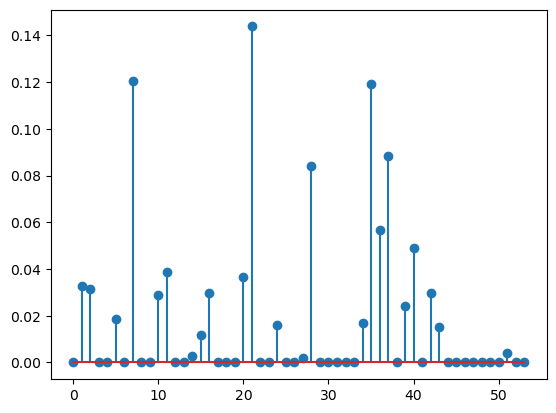

In [97]:
plt.stem(ww)

In [98]:
C

<xarray.DataArray 'close' (asset: 54, bucket: 150)>
array([[1.        , 1.00400618, 1.0011453 , ..., 0.97711762, 0.97711762,
        0.97768791],
       [1.        , 1.0033847 , 0.9966153 , ..., 0.99322749, 0.99172421,
        0.98984279],
       [1.        , 0.99548206, 0.99290418, ..., 0.98967784, 0.98967784,
        0.98967784],
       ...,
       [1.        , 1.01773775, 1.01773775, ..., 1.02217676, 1.01996639,
        1.02217676],
       [1.        , 0.99724371, 0.99264737, ..., 1.02159978, 1.02067976,
        1.02067976],
       [1.        , 1.00329003, 1.0090442 , ..., 1.03698238, 1.0378015 ,
        1.03451147]])
Coordinates:
  * asset     (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53
  * bucket    (bucket) object MultiIndex
  * day       (bucket) int32 569 569 569 569 569 569 ... 571 571 571 571 571 571
  * timeslot  (bucket) int32 1 2 3 4 5 6 7 8 9 10 ... 42 43 44 45 46 47 48 49 50

<StemContainer object of 3 artists>

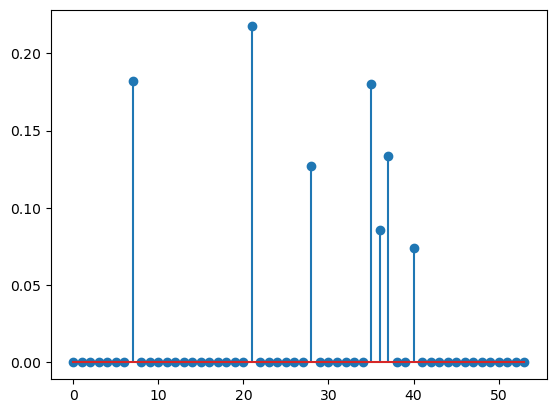

In [99]:
w_clipped = ww[:, 0] * (ww[:, 0] > 4e-2)
w_clipped /= w_clipped.sum()
composed_close = np.einsum('ji,j->i', C.as_numpy(), w_clipped)
plt.stem(w_clipped)

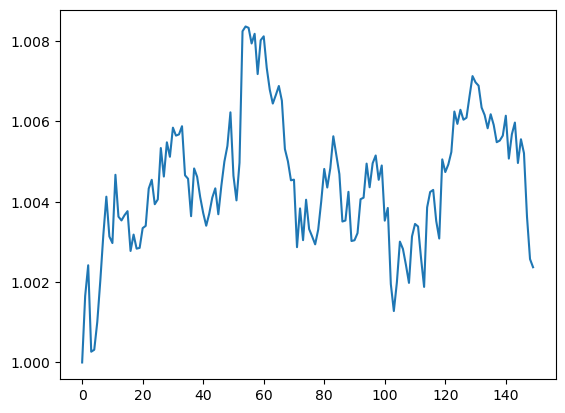

In [100]:
plt.plot(composed_close)

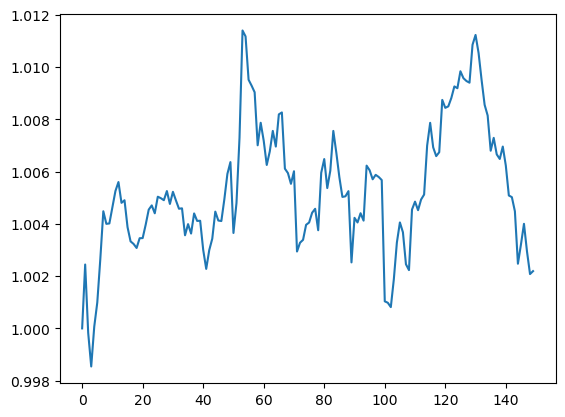

In [101]:
plt.plot(C.mean(dim='asset').as_numpy())

In [125]:
corr_day = 10
losses = np.zeros(1700-corr_day-1)
long_hedges = np.zeros((1700-corr_day-1, 54))
for i in trange(1, 1700-corr_day-1):
    C = ds.sel(day=range(i, i+corr_day))['close'].stack({'bucket': ('day', 'timeslot')})
    C /= C.isel(bucket=0)
    R = C.diff(dim='bucket') * 50

    A = R.to_numpy() @ R.to_numpy().T

    P = matrix(A)
    q = matrix(np.zeros(54))
    G = spdiag(matrix(-np.ones(54)))
    h = matrix(np.zeros(54))
    A1 = matrix(np.ones((1, 54)))
    b = matrix(1.0)

    result = qp(P, q, G, h, A1, b)
    long_hedges[i, :] = np.array(result['x'])[:, 0]
    losses[i] = result['primal objective']


  0%|          | 0/1688 [00:00<?, ?it/s]

     pcost       dcost       gap    pres   dres
 0:  6.6293e-01 -3.7366e-01  6e+01  8e+00  8e+00
 1:  6.7486e-01 -2.3808e-01  3e+00  3e-01  3e-01
 2:  8.1558e-01  3.8458e-01  7e-01  4e-02  5e-02
 3:  8.3626e-01  7.4864e-01  1e-01  5e-03  5e-03
 4:  8.1683e-01  8.0689e-01  1e-02  3e-04  3e-04
 5:  8.1211e-01  8.1146e-01  7e-04  7e-06  8e-06
 6:  8.1169e-01  8.1167e-01  2e-05  9e-08  1e-07
 7:  8.1168e-01  8.1168e-01  2e-07  9e-10  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.7487e-01 -3.7004e-01  6e+01  8e+00  8e+00
 1:  6.8832e-01 -2.2849e-01  3e+00  3e-01  3e-01
 2:  8.6172e-01  4.2033e-01  7e-01  3e-02  4e-02
 3:  8.5684e-01  7.6533e-01  1e-01  4e-03  5e-03
 4:  8.3598e-01  8.2576e-01  1e-02  2e-04  2e-04
 5:  8.3165e-01  8.3088e-01  8e-04  8e-06  9e-06
 6:  8.3124e-01  8.3119e-01  5e-05  1e-07  1e-07
 7:  8.3121e-01  8.3121e-01  2e-06  1e-09  1e-09
 8:  8.3121e-01  8.3121e-01  2e-08  1e-11  1e-11
Optimal solution found.
     pcost       dcost 

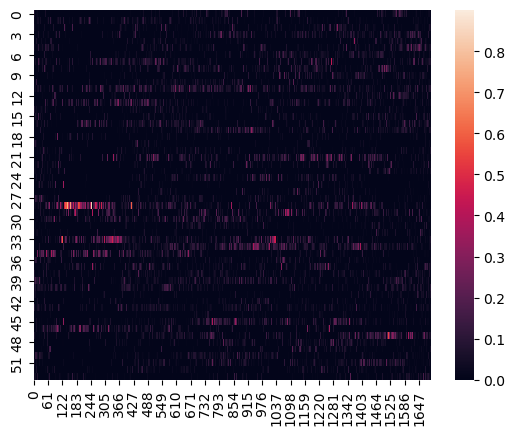

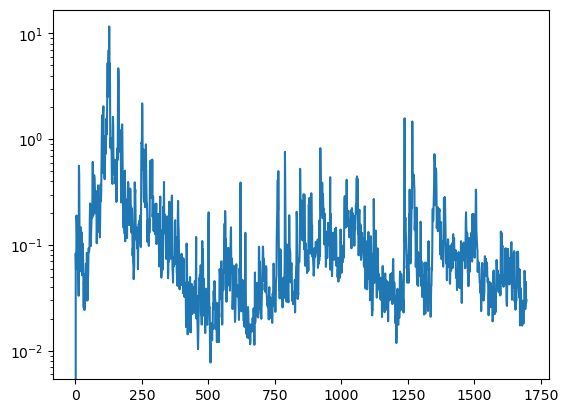

In [124]:
sns.heatmap(long_hedges.T)  # 2 day
plt.figure()
plt.semilogy(losses)

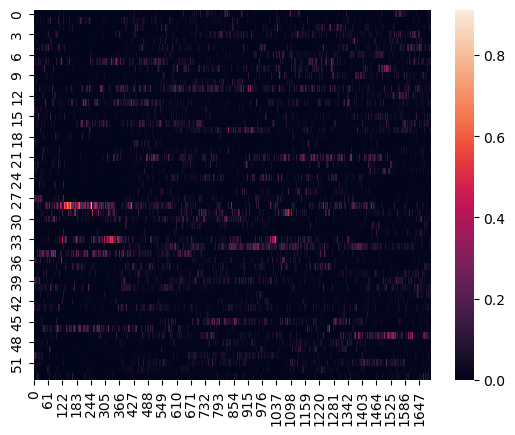

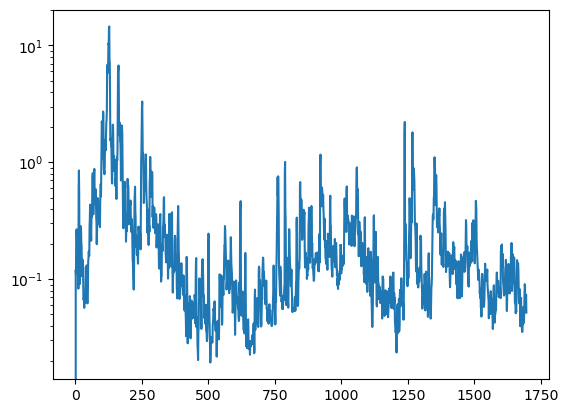

In [122]:
sns.heatmap(long_hedges.T)  # 3 day
plt.figure()
plt.semilogy(losses)

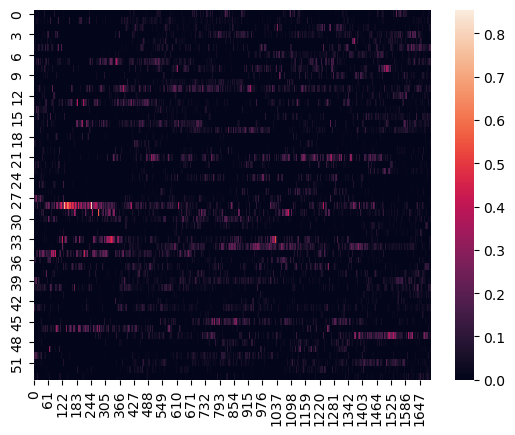

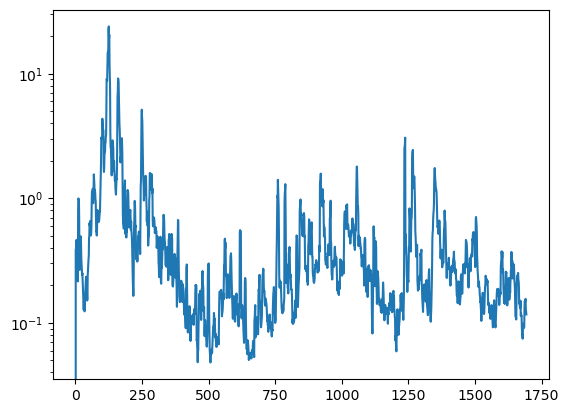

In [120]:
sns.heatmap(long_hedges.T)  # 5 day
plt.figure()
plt.semilogy(losses)

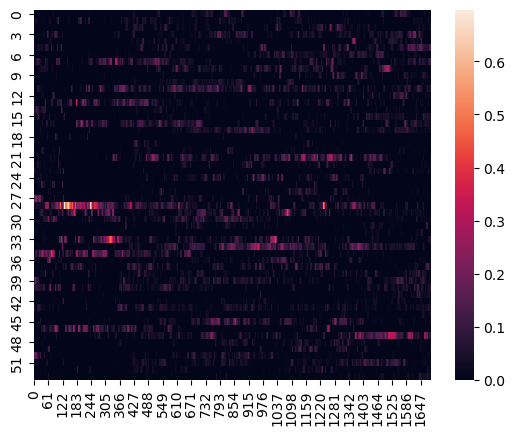

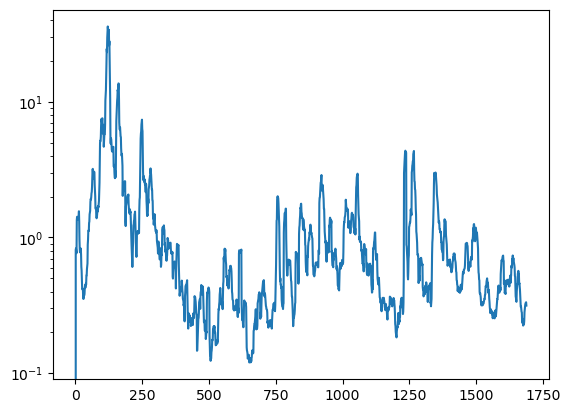

In [126]:
sns.heatmap(long_hedges.T)  # 10 day
plt.figure()
plt.semilogy(losses)

<AxesSubplot: >

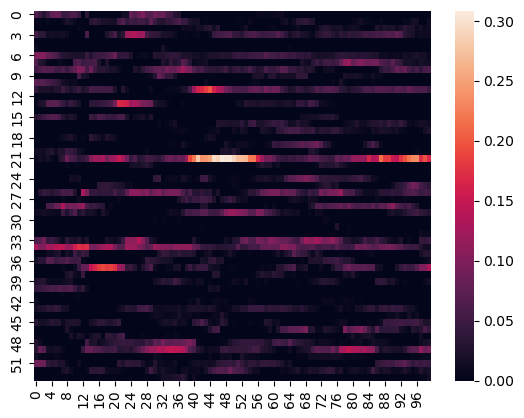

In [127]:
sns.heatmap(long_hedges[1100:1200, :].T)  # 10 day

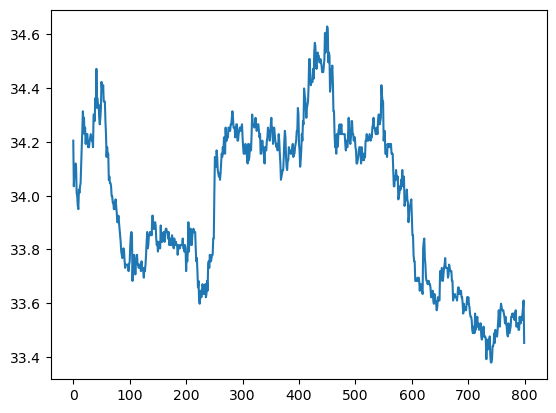

In [130]:
plt.plot(ds['close'].sel(asset=21,day=range(1140, 1156)).stack({'bucket': ('day', 'timeslot')}).as_numpy())

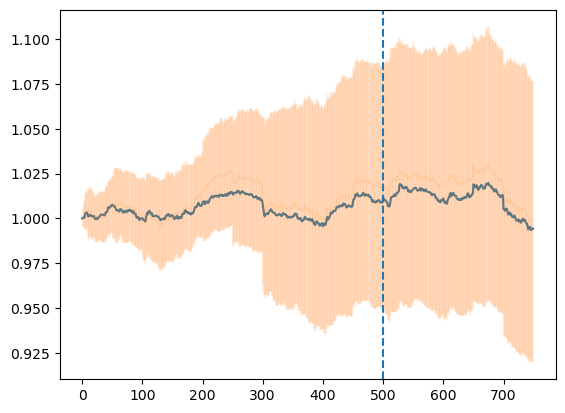

In [140]:
dayd = 1172
C = ds.sel(day=range(dayd, dayd+15))['close'].stack({'bucket': ('day', 'timeslot')})
C /= C.isel(bucket=0)
ww = long_hedges[dayd, :]
plt.plot(np.einsum('ji,j->i', C.as_numpy(), ww))
sstd = C.std(dim='asset')
plt.errorbar(np.arange(15*50), C.mean(dim='asset').as_numpy(), yerr=sstd, alpha=0.1)
plt.axvline(500, ls='--')